In [9]:
import numpy as np
import os
from os.path import join, isdir, getsize, exists
from nltk.stem.snowball import SnowballStemmer
import json
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib notebook

# Load and proprocess documents
**Load document labels**

In [2]:
segmented_path = u'./corpus/segmented-docs' # it will listdir into unicode
doc_labels = [fn for fn in os.listdir(segmented_path) if isdir(join(segmented_path, fn))] # list only folders
doc_labels_idx = {}
n_labels = len(doc_labels)
for i, label in enumerate(doc_labels):
    print i, label
    doc_labels_idx[label] = i
print 'Total Labels:', n_labels

0 บริหารธุรกิจ
1 ประมง
2 มนุษยศาสตร์
3 วนศาสตร์
4 วิทยาการจัดการ
5 วิทยาศาสตร์
6 วิทยาศาสตร์การกีฬา
7 วิศวกรรมศาสตร์
8 ศิลปศาสตร์และวิทยาศาสตร์
9 ศึกษาศาสตร์
10 ศึกษาศาสตร์และพัฒนศาสตร์
11 สถาปัตยกรรมศาสตร์
12 สังคมศาสตร์
13 สัตวแพทยศาสตร์
14 สิ่งแวดล้อม
15 อุตสาหกรรมเกษตร
16 เกษตร
17 เศรษฐศาสตร์
18 โครงการจัดตั้งวิทยาเขตสุพรรณบุรี
19 โครงการสหวิทยาการระดับบัณฑิตศึกษา
Total Labels: 20


** Load dataset **

In [3]:
%%time
dataset_contents, dataset_labels = [], []
for i, label in enumerate(doc_labels):
    curr_dir = join(segmented_path, label)
    fns = os.listdir(curr_dir)
    for fn in fns:
        file_path = join(curr_dir, fn)
        with open(file_path, 'r') as f:
            content = unicode(f.read(), 'utf8')
            dataset_contents.append(content)
            dataset_labels.append(i)
N = len(dataset_contents)
print 'Total Segmented Documents:', N

Total Segmented Documents: 2569
Wall time: 2min 11s


**Test English word stemmer from Natural Language Toolkit**

In [4]:
stemmer = SnowballStemmer('english')
test_words = u'reply represent representation representative expression cats feeling นำเสนอนะ'.split()
for word in test_words:
    print word, stemmer.stem(word)

reply repli
represent repres
representation represent
representative repres
expression express
cats cat
feeling feel
นำเสนอนะ นำเสนอนะ


** Define a function that trims and stems words then replace all PIPELINE by space **

In [5]:
def pretty_trim(text):
    words = text.split('|')
    stripped_words_generator = (word.strip() for word in words)
    stemmed_words_generator = (stemmer.stem(word) for word in stripped_words_generator)
    trimmed_words = (word for word in stemmed_words_generator if word) # retains words that are not empty
    return ' '.join(trimmed_words)

**Show sample content**

In [6]:
print 'Content:', dataset_contents[1][:2**8], '...'
print 'Label:', dataset_labels[1]

Content: I|49737869|Ipage| |I|วิทยานิพนธ์|P|การ|วิเคราะห์|ต้นทุน|ต่อ|หน่วย|ผลผลิต| |ใน|การผลิต|บัณฑิต|ระดับ|ปริญญาตรี|ของ|วิทยาลัย|เอกชน| |จังหวัด|สุราษฎร์ธานี|Ianalysis| |of| |cost| |per| |output| |unit| |in| |producing| |undergraduates| |Iof| |a| |private| |colle ...
Label: 0


** Show sample content after pretty_trimmed() **

In [7]:
print 'Content:', pretty_trim(dataset_contents[1][:2**8]), '...'
print 'Label Str:', doc_labels[dataset_labels[1]]

Content: i 49737869 ipag i วิทยานิพนธ์ p การ วิเคราะห์ ต้นทุน ต่อ หน่วย ผลผลิต ใน การผลิต บัณฑิต ระดับ ปริญญาตรี ของ วิทยาลัย เอกชน จังหวัด สุราษฎร์ธานี ianalysi of cost per output unit in produc undergradu iof a privat coll ...
Label Str: บริหารธุรกิจ


## Trim and stem all documents

In [10]:
%%time
fp = u'./corpus/dataset_contents_trimmed.json'
if exists(fp):
    print 'Loading trimmed documents ...'
    with open(fp, 'r') as f:
        dataset_contents_trimmed = json.load(f)
else:
    print 'Trimming documents ...'
    dataset_contents_trimmed = map(pretty_trim, dataset_contents)
    print 'Dumping ...'
    # dumb into a big file for later use because this list is very costful to compute
    with open(fp, 'w') as f:
        json.dump(dataset_contents_trimmed, f, ensure_ascii=True)
    print 'Size in GB:', getsize(fp) / 1024.0 / 1024.0 / 1024.0

Loading trimmed documents ...
Wall time: 1min 10s


In [11]:
del dataset_contents

** Count number of words for each document **

In [12]:
%time dataset_words_count = np.array([len(content.split()) for content in dataset_contents_trimmed])
print 'Words Count Mean: ', np.mean(dataset_words_count)
dataset_words_count[:min(40,N)]

Wall time: 8.99 s
Words Count Mean:  37835.5130401


array([41235, 63171, 24706, 41920, 38319, 39107, 43159, 53636, 32753,
       46280, 36777, 48854, 25723, 33029, 31878, 47538, 39423, 37125,
       35574, 32835, 22382, 25550, 20814, 40224, 51160, 51406, 40825,
       27288, 40376, 39074, 51784, 63060, 36307, 44400, 75625, 48855,
       49474, 62530, 55157, 42603])

** Show words count histogram **

<IPython.core.display.Javascript object>


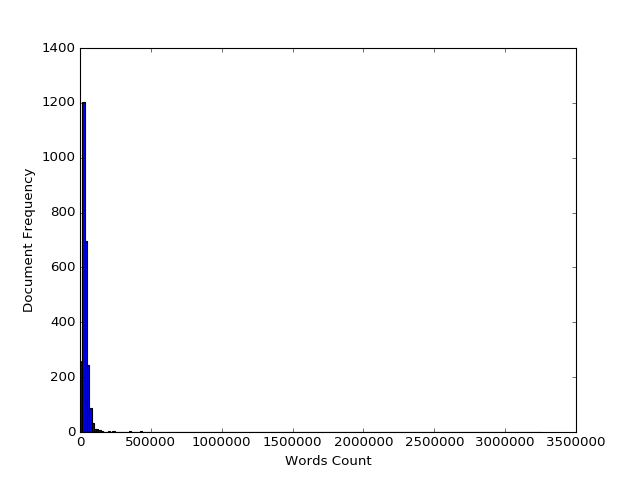

In [13]:
plt.figure()
plt.hist(dataset_words_count, bins=200)
plt.xlabel('Words Count')
plt.ylabel('Document Frequency')
plt.show()

# Machine Learning section

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.neural_network import BernoulliRBM
from collections import Counter
from scipy.sparse import vstack

## Train/Test Split
Split dataset into 2 parts and leave the test part untouched (not fitting it with any model)

Split using stratified sampling might be useful if you want to test all label including the skewed low frequency label

In [15]:
X_train, X_test, y_train, y_test = train_test_split(dataset_contents_trimmed, np.array(dataset_labels),
                                                    test_size=0.2, stratify=dataset_labels, random_state=42)
print 'Train Size:', len(X_train)
print 'Test Size:', len(X_test)
train_counter, test_counter = Counter(y_train), Counter(y_test)
print 'Un-trained label:', list(set(xrange(n_labels)) - set(train_counter))
print 'Un-tested label:', list(set(xrange(n_labels)) - set(test_counter))

Train Size: 2056
Test Size: 513
Un-trained label: []
Un-tested label: []


### Plot bar chart of dataset frequency per label

<IPython.core.display.Javascript object>


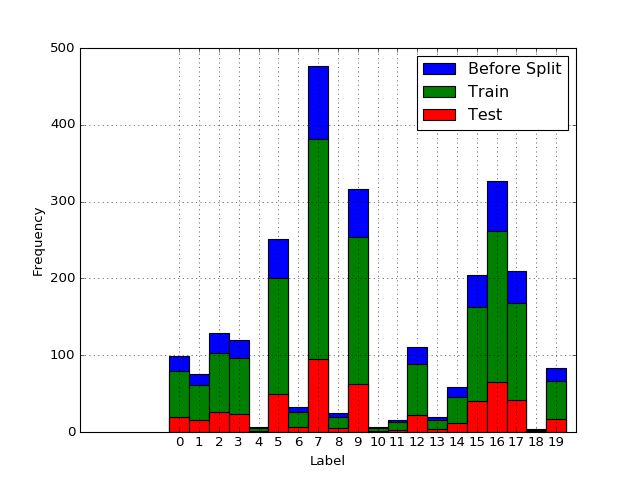

In [16]:
train_label_freqs = np.zeros(n_labels, np.int32)
test_label_freqs = np.zeros(n_labels, np.int32)
dataset_label_freqs = np.zeros(n_labels, np.int32)
for k,v in train_counter.iteritems():
    train_label_freqs[k] = v
for k,v in test_counter.iteritems():
    test_label_freqs[k] = v
for k,v in Counter(dataset_labels).iteritems():
    dataset_label_freqs[k] = v
plt.figure()
plt.bar(np.arange(n_labels)-0.5, dataset_label_freqs, 1, color='b')
plt.bar(np.arange(n_labels)-0.5, train_label_freqs, 1, color='g')
plt.bar(np.arange(n_labels)-0.5, test_label_freqs, 1, color='r')
plt.xticks(np.arange(len(doc_labels)))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.legend(['Before Split','Train', 'Test'], loc='best')
plt.grid()
plt.show()

## Feature Extraction
### Bag of Words Representation
Initialize a vectorizer that counts word instances and apply Tfidf (Term-Frequency * Inverse-Document-Frequency) to them

In [18]:
%%time
tfidf = TfidfVectorizer(encoding=u'utf-8', stop_words='english', binary=False, max_features=100000)
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

Wall time: 2min 14s


** Save extracted feature names to disk **

In [19]:
%%time
feature_names = tfidf.get_feature_names()
fn = 'feature_names.txt'
with open(fn, 'w') as f:
    f.write(u'\n'.join(feature_names).encode('utf8'))
print 'Check file %s to see all extracted feature names' % fn
print 'Total names:', len(feature_names)

Check file feature_names.txt to see all extracted feature names
Total names: 100000
Wall time: 323 ms


**Vectorized Dataset Statistics**

In [20]:
print 'Train Shape:', X_train_vectorized.shape
print 'Sample content of type %s:' % type(X_train_vectorized)
print X_train_vectorized

Train Shape: (2056, 100000)
Sample content of type <class 'scipy.sparse.csr.csr_matrix'>:
  (0, 52328)	0.000513878275034
  (0, 87272)	0.000351672084039
  (0, 99083)	0.00101656316808
  (0, 73195)	0.00111790963255
  (0, 89504)	0.00095086299023
  (0, 94135)	0.000675658285523
  (0, 92916)	0.000621585700223
  (0, 41016)	0.000494441306016
  (0, 43748)	0.0011047676612
  (0, 25297)	0.000621066859114
  (0, 27359)	0.00179697409365
  (0, 82709)	0.00166816018528
  (0, 54389)	0.00064114972261
  (0, 92833)	0.00037957922463
  (0, 97654)	0.00111480874076
  (0, 93942)	0.000504950971365
  (0, 85174)	0.000716497265029
  (0, 89579)	0.00122864617613
  (0, 84749)	0.00122340635829
  (0, 99117)	0.000742764674776
  (0, 85266)	0.000644467833899
  (0, 85415)	0.00109510087168
  (0, 88316)	0.000417729239667
  (0, 87597)	0.000714993203829
  (0, 89187)	0.000790981865953
  :	:
  (2055, 87595)	0.00290507694036
  (2055, 91636)	0.00209248752238
  (2055, 60697)	0.00549793757531
  (2055, 94639)	0.000491390440965
  (2055, 

## Feature Selection

Recursive feature elimination using weights of Linear Kernel Support Vector Machine

In [21]:
%%time
rfe = RFE(SGDClassifier(loss='hinge'), n_features_to_select=20000, step=0.2)
X_train_selected = rfe.fit_transform(X_train_vectorized, y_train)
X_test_selected = rfe.transform(X_test_vectorized)
print X_train_selected.shape, X_test_selected.shape

(2056, 20000) (513, 20000)
Wall time: 7.64 s


** Save top feature names to file **

In [22]:
%%time
top_features = [feature for feature, support in zip(feature_names, rfe.support_) if support]
file_name = 'feature_names_top.txt'
with open(file_name, 'w') as f:
    f.write(u'\n'.join(top_features).encode('utf8'))
print 'Go check file %s' % file_name

Go check file feature_names_top.txt
Wall time: 165 ms


## Dimensionality Reduction

#### Unsupervised non-linear dimension reduction

Pre-training with Bernoulli Restricted Boltzmann Machine

In [91]:
# %%time
# rbm = BernoulliRBM(n_components=50, learning_rate=0.2, batch_size=20, n_iter=20, random_state=42, verbose=1)
# X_train_rbm = rbm.fit_transform(X_train_selected)
# X_test_rbm = rbm.transform(X_test_selected)
# print X_train_rbm.shape

[BernoulliRBM] Iteration 1, pseudo-likelihood = -452.91, time = 8.04s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -35.33, time = 8.45s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -19.68, time = 8.61s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -16.75, time = 8.38s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -14.76, time = 8.89s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -15.02, time = 9.84s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -14.44, time = 7.73s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -13.56, time = 7.60s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -12.23, time = 7.61s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -12.87, time = 6.79s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -12.21, time = 8.57s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -12.50, time = 9.43s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -12.68, time = 7.47s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -12.86, time = 10.05s
[BernoulliRBM] Iteration 15

In [92]:
# print rbm.components_.shape
# print rbm.components_ # weight of each edge, components_[i,j] = weight of edge from hidden node i to visible node j

(50L, 20000L)
[[-0.03572855 -0.05813121 -0.0562077  ..., -0.13155343 -0.07418611
  -0.14079532]
 [-0.03441731 -0.02968999 -0.05920262 ..., -0.09267987 -0.06091394
  -0.10048683]
 [-0.04704162 -0.04297848 -0.06149489 ..., -0.1244551  -0.11109585
  -0.12007697]
 ..., 
 [-0.01286344 -0.03939054 -0.05986788 ..., -0.10667528 -0.06860802
  -0.1033964 ]
 [-0.04138484 -0.05222536 -0.05048636 ..., -0.12131422 -0.07424998
  -0.1004438 ]
 [-0.04486198 -0.02612365 -0.04348389 ..., -0.10224552 -0.0587047
  -0.10635221]]


Truncated SVD (Single Value Decomposition) is called Latent Semantic Analysis (LSA) in text analysis context

In [345]:
# %%time
# svd = TruncatedSVD(n_components=200) # works on sparse data
# X_train_reduced = svd.fit_transform(X_train_selected)
# X_test_reduced = svd.transform(X_test_selected)
# print 'Train Shape:', X_train_reduced.shape
# print 'Explained Variance Ratio Sum:', svd.explained_variance_ratio_.sum()
# print 'Top 5 Explained Variance Ratio:', svd.explained_variance_ratio_[:5]

Train Shape: (620L, 200L)
Explained Variance Ratio Sum: 0.680931519226
Top 5 Explained Variance Ratio: [ 0.08757407  0.0295904   0.01745794  0.01065465  0.01066833]
Wall time: 1.93 s


## Training models

In [152]:
X_train_final, X_test_final = X_train_selected, X_test_selected

In [153]:
%%time
models = [LogisticRegression(), DecisionTreeClassifier(max_depth=15),
          SGDClassifier(n_iter=20), KNeighborsClassifier(n_neighbors=2), Perceptron(), RandomForestClassifier()]
for clf in models:
    print 'Training', type(clf).__name__
    %time clf.fit(X_train_final, y_train)

Training LogisticRegression
Wall time: 13.6 s
Training DecisionTreeClassifier
Wall time: 8.01 s
Training SGDClassifier
Wall time: 3.14 s
Training KNeighborsClassifier
Wall time: 31 ms
Training Perceptron
Wall time: 805 ms
Training RandomForestClassifier
Wall time: 1.33 s
Wall time: 26.9 s


## Models Scoring
Evaluate on both train and test set

In [154]:
for clf in models:
    print type(clf).__name__
    for X,y,t in [(X_train_final, y_train, 'Train'), (X_test_final, y_test, 'Test')]:
        pred = clf.predict(X) # change to reduced or selected for 2 ways of reducing dimensions
        print t, 'dataset'
        print 'Accuracy Score:', accuracy_score(y, pred)
        print 'Precision Recall F-Score:\n', precision_recall_fscore_support(y, pred, average='weighted')
    print

LogisticRegression
Train dataset
Accuracy Score: 0.790369649805
Precision Recall F-Score:
(0.75089632217245306, 0.79036964980544744, 0.75812390949076058, None)
Test dataset
Accuracy Score: 0.688109161793
Precision Recall F-Score:
(0.63096403801924783, 0.68810916179337234, 0.64529838257052885, None)

DecisionTreeClassifier
Train dataset
Accuracy Score: 0.888618677043
Precision Recall F-Score:
(0.91925983665225941, 0.88861867704280151, 0.89263670854663835, None)
Test dataset
Accuracy Score: 0.686159844055
Precision Recall F-Score:
(0.70800753406520478, 0.68615984405458086, 0.6874481221760026, None)

SGDClassifier
Train dataset
Accuracy Score: 0.987840466926
Precision Recall F-Score:
(0.98800846656404928, 0.98784046692607008, 0.9874596100660763, None)
Test dataset
Accuracy Score: 0.7738791423
Precision Recall F-Score:
(0.74607523507315621, 0.77387914230019494, 0.75379071906759398, None)

KNeighborsClassifier
Train dataset
Accuracy Score: 0.798151750973
Precision Recall F-Score:
(0.8267294

## Train a Model with Cross-Validation Set
**Support Vector Machine implemented using Stochastic Gradient Descent**

Tune the model's hyper-parameters to give high K-Fold CV score

In [156]:
%%time
params = {'alpha':[1e-3, 1e-4, 1e-5, 1e-6], 'n_iter':[20]}
gs = GridSearchCV(SGDClassifier(random_state=42), params, scoring='f1_weighted', cv=3)
gs.fit(X_train_final, y_train)

Wall time: 29.6 s


In [157]:
print gs.best_estimator_
print gs.best_params_
print gs.best_score_

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=20, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)
{'alpha': 0.0001, 'n_iter': 20}
0.736016669319


In [158]:
clf = gs.best_estimator_
print type(clf).__name__
for X,y,t in [(X_train_final, y_train, 'Train'), (X_test_final, y_test, 'Test')]:
    pred = clf.predict(X) # change to reduced or selected to change ways of reducing dimensions
    print '=>', t, 'dataset'
    print 'Accuracy Score:', accuracy_score(y, pred)
    print 'Precision Recall F-Score:\n', precision_recall_fscore_support(y, pred, average='weighted')
    print
print 'Baseline score by chance:', 1.0 / n_labels, '(assume that an algorithm randomly guesses the label)'

SGDClassifier
=> Train dataset
Accuracy Score: 0.989299610895
Precision Recall F-Score:
(0.98943159292375393, 0.98929961089494167, 0.98895381497536483, None)

=> Test dataset
Accuracy Score: 0.789473684211
Precision Recall F-Score:
(0.77202196505336917, 0.78947368421052633, 0.77566382091531416, None)

Baseline score by chance: 0.05 (assume that an algorithm randomly guesses the label)


## Model Evaluation Metrics
Visualize confusion matrix and show classification report

In [159]:
y_true, y_pred = y_test, clf.predict(X_test_final)

### Confusion Matrix
Visualize true positives and false positives

In [160]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(n_labels)
    plt.xticks(tick_marks, rotation=0)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[14  0  0  0  0  0  1  1  0  0  0  0  1  0  0  0  0  3  0  0]
 [ 1 10  0  0  0  1  0  0  0  1  0  0  0  0  0  1  1  0  0  0]
 [ 1  0 23  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0]
 [ 0  0  1 19  0  0  0  2  0  0  0  0  0  0  1  0  0  1  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  1  0 27  0  7  0  0  0  0  0  0  2  1  6  0  0  4]
 [ 0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0 91  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  2  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0 62  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  2  1  0  0  0  1  0  2  0  0 16  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  1  0  2  0  0  0  3  0  0  0  0  0  0  4  0  0  2  0  0]
 [ 1  0  0  0  

<IPython.core.display.Javascript object>


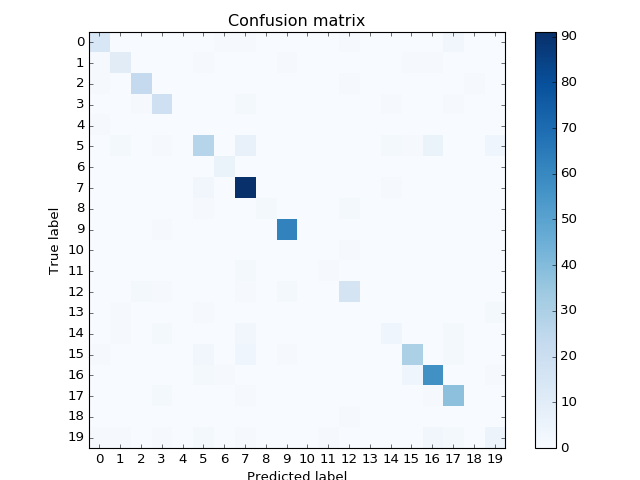

Normalized confusion matrix (Had to scale by 99 not 100 because the matrix will be too big and wrap lines)
[[69  0  0  0  0  0  4  4  0  0  0  0  4  0  0  0  0 14  0  0]
 [ 6 66  0  0  0  6  0  0  0  6  0  0  0  0  0  6  6  0  0  0]
 [ 3  0 87  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  3  0]
 [ 0  0  4 78  0  0  0  8  0  0  0  0  0  0  4  0  0  4  0  0]
 [99  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  1  0 53  0 13  0  0  0  0  0  0  3  1 11  0  0  7]
 [ 0  0  0  0  0  0 99  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0 94  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0 39  0  0  0 39  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0 97  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 99  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 66  0  0  0 33  0  0  0  0  0  0  0  0]
 [ 0  0  9  4  0  0  0  4  0  9  0  0 72  0  0  0  0  0  0  0]
 [ 0 24  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0 49]
 [ 0  8  0 

<IPython.core.display.Javascript object>


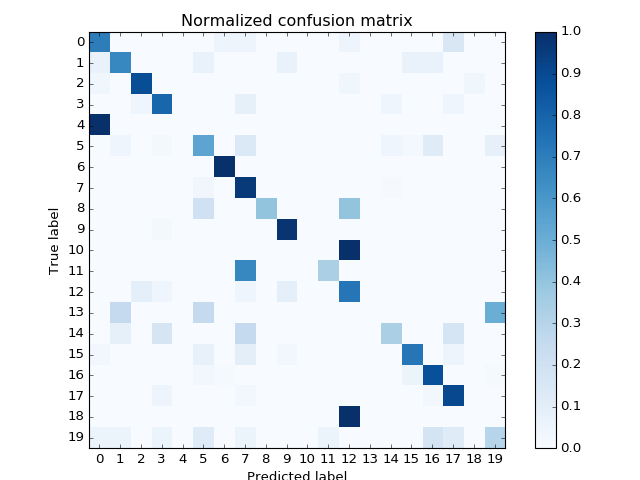

In [161]:
cm = confusion_matrix(y_true, y_pred)
print 'Confusion matrix, without normalization'
print cm
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print 'Normalized confusion matrix (Had to scale by 99 not 100 because the matrix will be too big and wrap lines)'
print (cm_normalized * 99).astype('int')
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

### Classification Report
Show scoring like precision, recall, f1 and their average for each label

In [162]:
print classification_report(y_true, y_pred, target_names=None)

             precision    recall  f1-score   support

          0       0.74      0.70      0.72        20
          1       0.67      0.67      0.67        15
          2       0.88      0.88      0.88        26
          3       0.70      0.79      0.75        24
          4       0.00      0.00      0.00         1
          5       0.68      0.54      0.60        50
          6       0.75      1.00      0.86         6
          7       0.81      0.96      0.88        95
          8       1.00      0.40      0.57         5
          9       0.94      0.98      0.96        63
         10       0.00      0.00      0.00         1
         11       0.50      0.33      0.40         3
         12       0.73      0.73      0.73        22
         13       0.00      0.00      0.00         4
         14       0.50      0.33      0.40        12
         15       0.83      0.73      0.78        41
         16       0.84      0.88      0.86        65
         17       0.79      0.90      0.84   

## Learning Curves
Watch the performance of our chosen model as we increase the training size and check if it has variance or bias or somewhere in between

In [163]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-Score Weighted of CVs")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring='f1_weighted',
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="%d-Fold Cross-validation score" % cv)

    plt.legend(loc="best")
    return plt

<IPython.core.display.Javascript object>


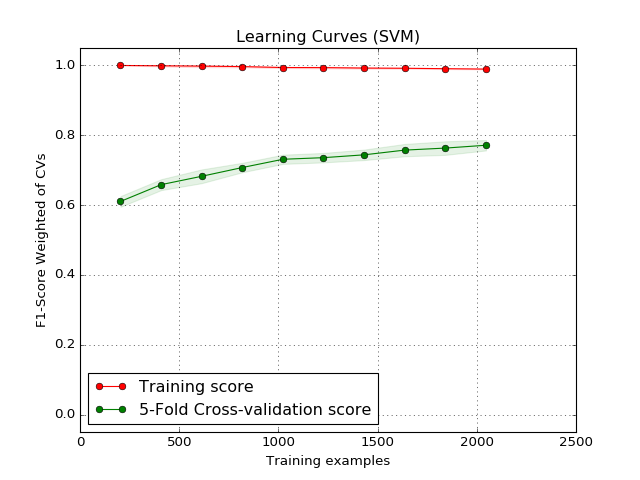

Wall time: 1min 25s


In [164]:
%%time
# cv = ShuffleSplit(X_train_selected.shape[0], n_iter=5, test_size=0.2, random_state=42)
title = 'Learning Curves (SVM)'
X = vstack((X_train_final, X_test_final))
y = np.concatenate((y_train, y_test))
plot_learning_curve(clf, title, X, y, ylim=(-0.05, 1.05), cv=5, n_jobs=1)
plt.show()